In [2]:
import sys
import os
import math

from progressbar import ProgressBar, Bar, ETA, Percentage, SimpleProgress
#from ipyparallel import Client

# parallelization
#client = Client(profile='default')

import ROOT
ROOT.gROOT.SetBatch(True)

from DevTools.Analyzer.utilities import deltaR, deltaPhi

# load FWLite C++ libraries
ROOT.gSystem.Load("libFWCoreFWLite.so");
ROOT.gSystem.Load("libDataFormatsFWLite.so");
ROOT.AutoLibraryLoader.enable()

# load FWlite python libraries
from DataFormats.FWLite import Handle, Events

# plotting
import DevTools.Plotter.CMS_lumi as CMS_lumi
import DevTools.Plotter.tdrstyle as tdrstyle
tdrstyle.setTDRStyle()
ROOT.gStyle.SetPalette(1)

import rootnotes
canvas = rootnotes.default_canvas()

In [3]:

DeltaR = lambda a,b: deltaR(a.eta(),a.phi(),b.eta(),b.phi())
DeltaPhi = lambda a,b: deltaPhi(a.phi(),b.phi())

def process(events,func,func_args=[],func_kwargs={},**kwargs):
    maxEvents = kwargs.pop('maxEvents',-1)
    reportEvery = kwargs.pop('reportEvery',1000)
    
    muons, muonLabel = Handle("std::vector<pat::Muon>"), "slimmedMuons"
    electrons, electronLabel = Handle("std::vector<pat::Electron>"), "slimmedElectrons"
    photons, photonLabel = Handle("std::vector<pat::Photon>"), "slimmedPhotons"
    taus, tauLabel = Handle("std::vector<pat::Tau>"), "slimmedTaus"
    jets, jetLabel = Handle("std::vector<pat::Jet>"), "slimmedJets"
    mets, metLabel = Handle("std::vector<pat::MET>"), "slimmedMETs"
    vertices, vertexLabel = Handle("std::vector<reco::Vertex>"), "offlineSlimmedPrimaryVertices"
    beamspot, beamspotLabel = Handle("reco::BeamSpot"), "offlineBeamSpot"
    genParticles, genParticleLabel = Handle("std::vector<reco::GenParticle>"), "prunedGenParticles"

    if maxEvents<0: maxEvents = len(events)
    
    for i,event in enumerate(events):
        if maxEvents>=0 and i>maxEvents: break
        if i%reportEvery==1: print 'Processing event {0}'.format(i)
            
        event.getByLabel(muonLabel, muons) 
        event.getByLabel(electronLabel, electrons)
        event.getByLabel(photonLabel, photons)
        event.getByLabel(tauLabel, taus)
        event.getByLabel(jetLabel, jets)
        event.getByLabel(metLabel, mets)
        event.getByLabel(vertexLabel, vertices)
        event.getByLabel(beamspotLabel,beamspot)
        event.getByLabel(genParticleLabel,genParticles)
        
        func(i,
             event,
             *func_args,
             muons=muons,
             electrons=electrons,
             photons=photons,
             taus=taus,
             jets=jets,
             mets=mets,
             vertices=vertices,
             beamspot=beamspot,
             genParticles=genParticles,
             **func_kwargs)


In [4]:
def set_cms_style(pad,position=11,preliminary=True):
    '''Set style for plots based on the CMS TDR style guidelines.
       https://twiki.cern.ch/twiki/bin/view/CMS/Internal/PubGuidelines#Figures_and_tables
       https://ghm.web.cern.ch/ghm/plots/'''
    # set period (used in CMS_lumi)
    # period : sqrts
    # 1 : 7, 2 : 8, 3 : 7+8, 4 : 13, ... 7 : 7+8+13
    period_int = 4
    # set position
    # 11: upper left, 33 upper right
    CMS_lumi.wrtieExtraText = preliminary
    CMS_lumi.extraText = "Preliminary"
    CMS_lumi.lumi_13TeV = "%0.1f fb^{-1}" % (float(2310)/1000.)
    CMS_lumi.CMS_lumi(pad,period_int,position)
    
def set_hist_style(hist,style={}):
    hist.SetTitle(style['name'])
    if 'linecolor' in style: hist.SetLineColor(style['linecolor'])
    if 'linecolor' in style: hist.SetMarkerColor(style['linecolor'])
    if 'linewidth' in style: hist.SetLineWidth(style['linewidth'])
    if 'fillstyle' in style: hist.SetFillStyle(style['fillstyle'])
    if 'fillcolor' in style: hist.SetFillColor(style['fillcolor'])

def get_legend(hists,styles,**kwargs):
    '''Get the legend'''
    position = kwargs.pop('position',33)
    numcol = kwargs.pop('numcol',1)
    # programatically decide position
    # ----------------
    # | 14 | 24 | 34 |
    # ----------------
    # | 13 | 23 | 33 |
    # ----------------
    # | 12 | 22 | 32 |
    # ----------------
    # | 11 | 21 | 31 |
    # ----------------
    width = 0.15*numcol+0.1
    numentries = len(hists)
    height = math.ceil(float(numentries)/numcol)*0.06+0.02
    if position % 10 == 1:   # bottom
        ystart = 0.16
        yend = ystart+height
    elif position % 10 == 2: # middle
        yend = 0.54+height/2
        ystart = 0.54-height/2
    elif position % 10 == 3: # top
        yend = 0.84
        ystart = yend-height
    else:                    # verytop
        yend = 0.92
        ystart = yend-height
    if position / 10 == 1:   # left
        xstart = 0.19
        xend = xstart+width
    elif position / 10 == 2: # middle
        xstart = 0.57-width/2
        xend = 0.57+width/2
    else:                    # right
        xend = 0.95
        xstart = xend-width
    legend = ROOT.TLegend(xstart,ystart,xend,yend,'','NDC')
    if numcol>1: legend.SetNColumns(int(numcol))
    legend.SetTextFont(42)
    legend.SetBorderSize(0)
    legend.SetFillColor(0)
    for hist,style in zip(hists,styles):
        legend.AddEntry(hist,hist.GetTitle(),style['legendstyle'])
    return legend

In [5]:
events = {
    'hpp': Events("root://cmsxrootd.hep.wisc.edu//store/user/dntaylor/HPlusPlusHMinusMinusHTo4L_M-200_13TeV-pythia8/RunIIFall15MiniAODv2_MINIAODSIM_v3/160319_171746/0000/dblh_step1_1.root"),
    'dy' : Events("root://cmsxrootd.hep.wisc.edu//store/mc/RunIIFall15MiniAODv2/DYJetsToLL_M-50_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12-v1/00000/0C4FAF25-DAC7-E511-A535-BCAEC54E98B3.root"),
}


def fill(i,event,hists,**kwargs):
    muons = kwargs.pop('muons')
    vertices = kwargs.pop('vertices')
    beamspot = kwargs.pop('beamspot')
    
    pv = vertices.product()[0]
    bs = beamspot.product()
    zero = ROOT.Math.XYZPoint(0,0,0)
    
    for i,muon in enumerate(muons.product()):
        if not muon.genParticleRef().isNonnull(): continue # match to gen particle
        genMuon = muon.genParticle()
        if DeltaR(muon,genMuon)>0.1: continue              # gen particle within DR 0.1
        if not genMuon.isPromptFinalState(): continue      # gen particle is prompt

        pv_dz = muon.muonBestTrack().dz(pv.position())
        bs_dz = muon.muonBestTrack().dz(bs.position())
        zero_dz = muon.muonBestTrack().dz(zero)
        pv_dxy = muon.muonBestTrack().dxy(pv.position())
        bs_dxy = muon.muonBestTrack().dxy(bs.position())
        zero_dxy = muon.muonBestTrack().dxy(zero)
        
        hists['pv']['dz'].Fill(pv_dz)
        hists['bs']['dz'].Fill(bs_dz)
        hists['zero']['dz'].Fill(zero_dz)
        hists['pv']['dxy'].Fill(pv_dxy)
        hists['bs']['dxy'].Fill(bs_dxy)
        hists['zero']['dxy'].Fill(zero_dxy)

#lview = client.load_balanced_view()
results = []
hists = {}
for sample in ['hpp','dy']:
    hists[sample] = {}
    for m in ['pv','bs','zero']:
        hists[sample][m] = {}
        dzName = 'h_{0}_{1}_dz'.format(sample,m)
        dxyName = 'h_{0}_{1}_dxy'.format(sample,m)
        maxDZ = 0.5 if m=='pv' else 50.
        maxDXY = 0.5 if m=='pv' else 1.
        hists[sample][m]['dz'] = ROOT.TH1F(dzName,dzName,100,-maxDZ,maxDZ)
        hists[sample][m]['dxy'] = ROOT.TH1F(dxyName,dxyName,100,-maxDXY,maxDXY)


    process(events[sample],fill,func_args=[hists[sample]],maxEvents=10000)
    #results += [lview.apply_async(process,events[sample],fill,funct_args=[hists[sample]],maxEvents=10000)]

#[r.get() for r in results]

/afs/hep.wisc.edu/cms/dntaylor/ANALYZERS/CMSSW_7_6_3_patch2/src/venv/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: creating converter for unknown type "const char*const*"


Processing event 1
Processing event 1001
Processing event 2001
Processing event 3001
Processing event 4001
Processing event 5001
Processing event 6001
Processing event 7001
Processing event 8001
Processing event 9001
Processing event 1
Processing event 1001
Processing event 2001
Processing event 3001
Processing event 4001
Processing event 5001
Processing event 6001
Processing event 7001
Processing event 8001
Processing event 9001


In [6]:
def plot_normalized(histList,styleList,**kwargs):
    xaxis = kwargs.pop('xaxis','Variable')
    yaxis = kwargs.pop('yaxis','Unit Normalized')
    
    # get the maximum
    ymax = 0.
    for hist in histList:
        hist.Scale(1./hist.Integral())
        ymax = max(ymax,hist.GetMaximum())
        
    # draw hists
    for i,(hist,style) in enumerate(zip(histList,styleList)):
        set_hist_style(hist,style=style)
        if i==0:
            hist.Draw()
            hist.GetXaxis().SetTitle(xaxis)
            hist.GetYaxis().SetTitle(yaxis)
            hist.SetMaximum(1.2*ymax)
        else:
            hist.Draw('same')



In [7]:
styles = {
    'hpp' : {
        'name': '#Phi^{++}#Phi^{--} (Prompt)',
        'linecolor': ROOT.kRed,
        'linewidth': 2,
        'legendstyle': 'f',
    },
    'dy' : {
        'name': 'Drell-Yan (Prompt)',
        'linecolor': ROOT.kBlue,
        'linewidth': 2,
        'legendstyle': 'f'
    },
}

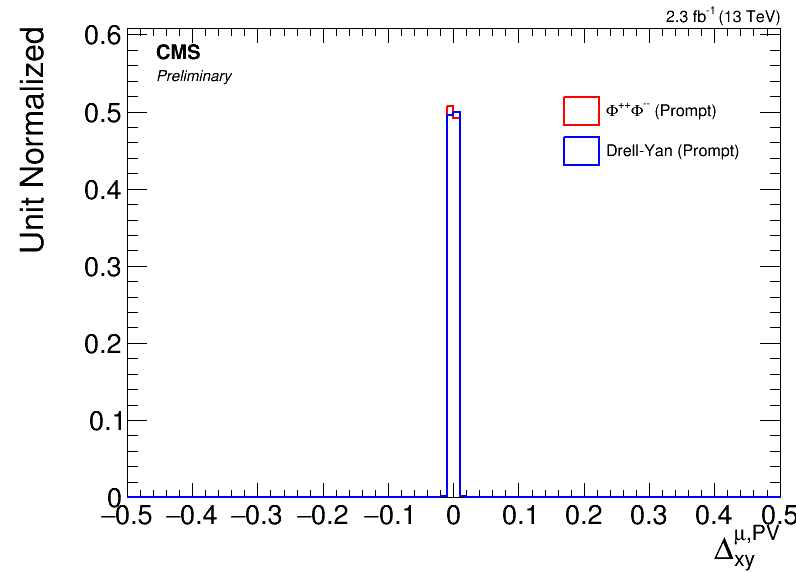

In [8]:
sampleList = ['hpp','dy']

histList = [hists[s]['pv']['dxy'] for s in sampleList]
styleList = [styles[s] for s in sampleList]

plot_normalized(histList,styleList,xaxis='#Delta^{#mu,PV}_{xy}')

legend = get_legend(histList,styleList)
legend.Draw('same')

set_cms_style(canvas)

canvas

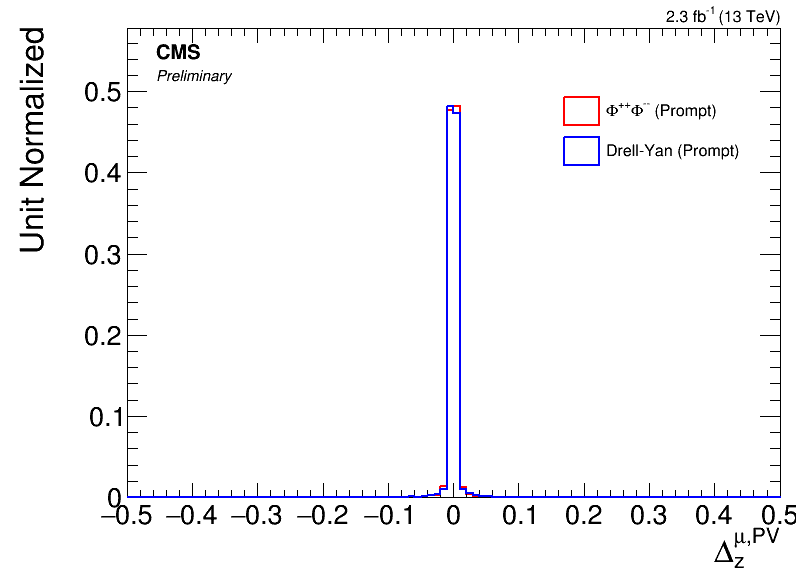

In [9]:
sampleList = ['hpp','dy']

histList = [hists[s]['pv']['dz'] for s in sampleList]
styleList = [styles[s] for s in sampleList]

plot_normalized(histList,styleList,xaxis='#Delta^{#mu,PV}_{z}')

legend = get_legend(histList,styleList)
legend.Draw('same')

set_cms_style(canvas)

canvas

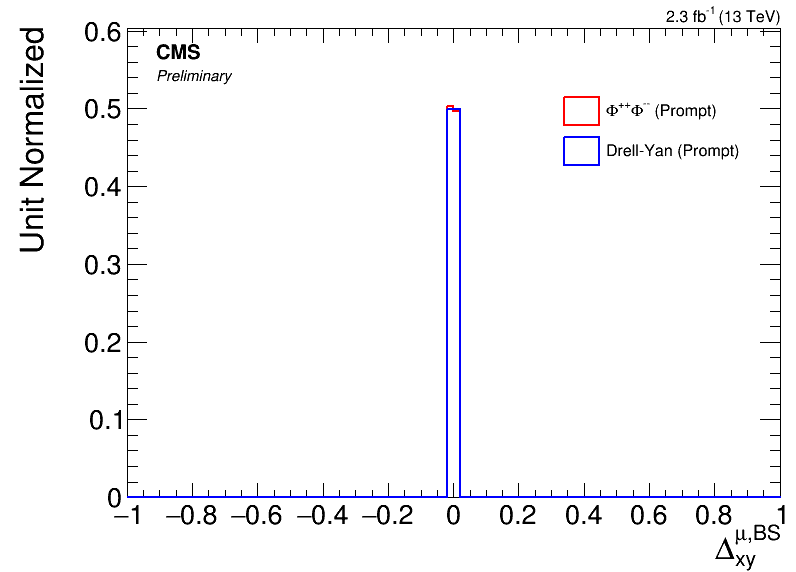

In [10]:
sampleList = ['hpp','dy']

histList = [hists[s]['bs']['dxy'] for s in sampleList]
styleList = [styles[s] for s in sampleList]

plot_normalized(histList,styleList,xaxis='#Delta^{#mu,BS}_{xy}')

legend = get_legend(histList,styleList)
legend.Draw('same')

set_cms_style(canvas)

canvas

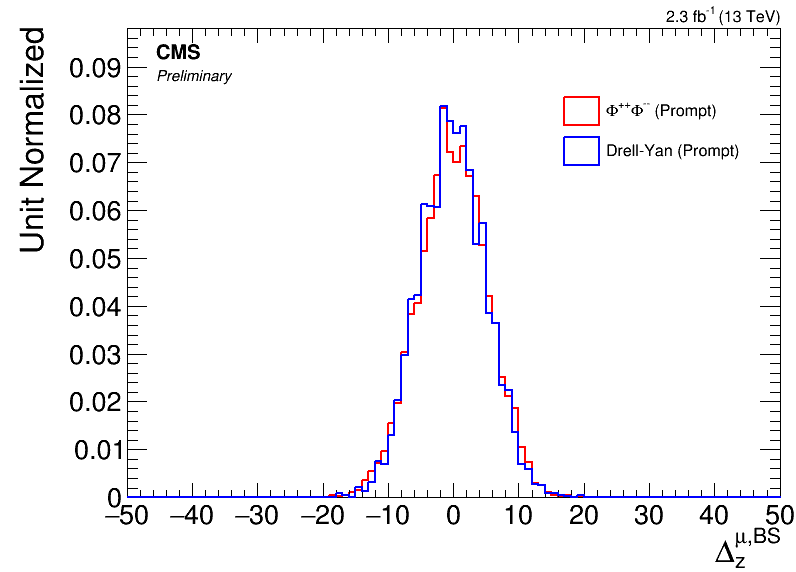

In [11]:
sampleList = ['hpp','dy']

histList = [hists[s]['bs']['dz'] for s in sampleList]
styleList = [styles[s] for s in sampleList]

plot_normalized(histList,styleList,xaxis='#Delta^{#mu,BS}_{z}')

legend = get_legend(histList,styleList)
legend.Draw('same')

set_cms_style(canvas)

canvas

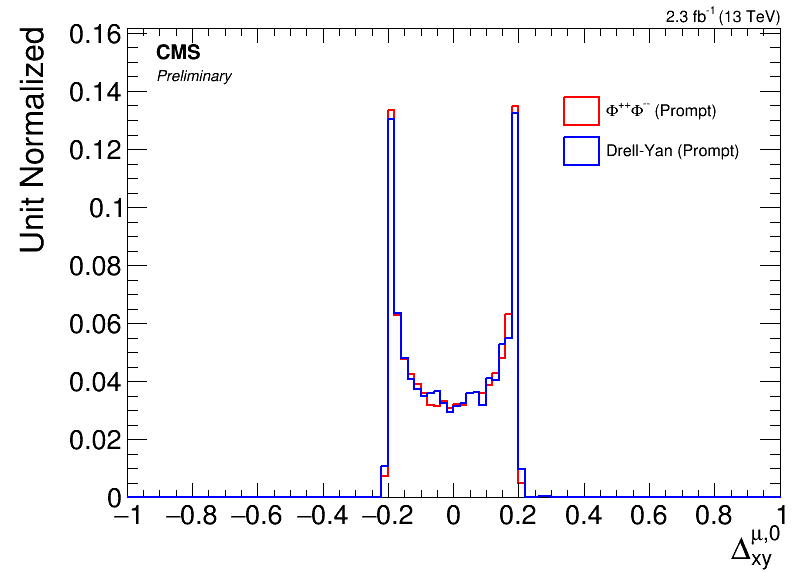

In [12]:
sampleList = ['hpp','dy']

histList = [hists[s]['zero']['dxy'] for s in sampleList]
styleList = [styles[s] for s in sampleList]

plot_normalized(histList,styleList,xaxis='#Delta^{#mu,0}_{xy}')

legend = get_legend(histList,styleList)
legend.Draw('same')

set_cms_style(canvas)

canvas

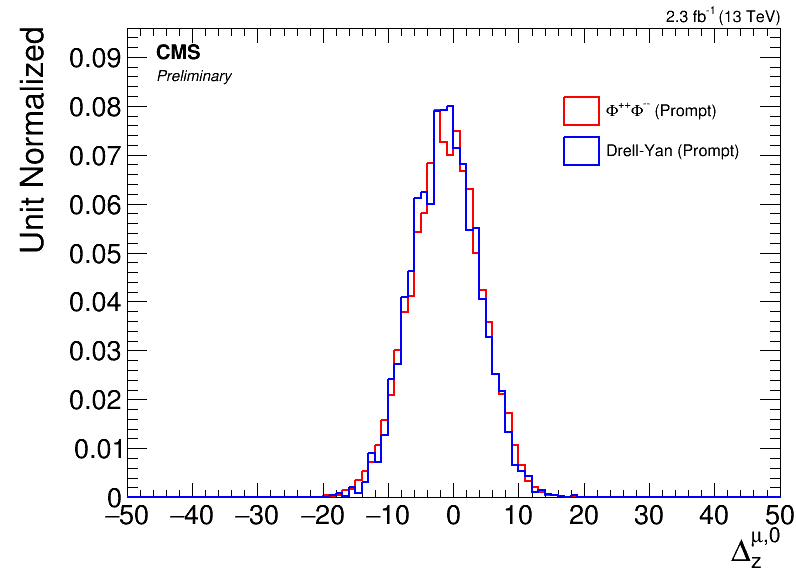

In [13]:
sampleList = ['hpp','dy']

histList = [hists[s]['zero']['dz'] for s in sampleList]
styleList = [styles[s] for s in sampleList]

plot_normalized(histList,styleList,xaxis='#Delta^{#mu,0}_{z}')

legend = get_legend(histList,styleList)
legend.Draw('same')

set_cms_style(canvas)

canvas